## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

## Visualization of Vessel Trajectory

This section visualizes the **trajectory** of a selected vessel by plotting its recorded longitude and latitude positions. The data is filtered for one vessel from the AIS dataset, and the path it has traveled is displayed as a line plot, illustrating its movement over time.


Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId'],
      dtype='object')
                  time    cog   sog  rot  heading  navstat       etaRaw  \
0  2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1  2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2  2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3  2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4  2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   

   latitude  longitude                  vesselId                    portId  
0 -34.74370  -57.85130  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07011a37f  
1   8.89440  -79.47939  61e9f3d4b937134a3c4bff1f  634c4de270937fc01c3a7689  
2  39.19065  -76.47567  61e9f436b937134a3c4c0131  61d3847bb7b7526e1adf3d19  
3 -34.41189  151.02067  61e9f3b4b937134a3c4bfe77  61d36f770a1807568ff9a126  
4  35.88379   -5.91

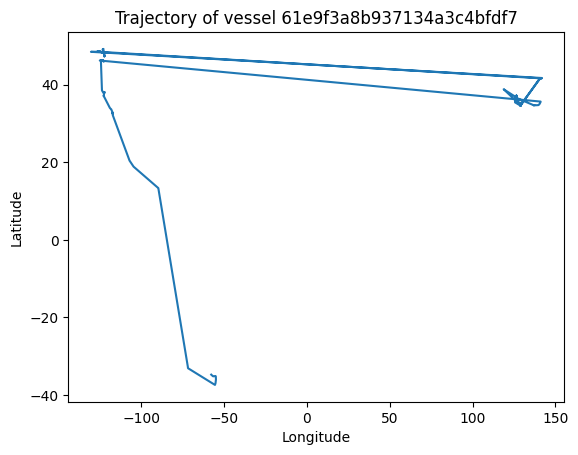

In [2]:
# Load AIS test data
ais_test = pd.read_csv('ais_test.csv')

# Load vessel schedules data
schedule = pd.read_csv('schedules_to_may_2024.csv')

# Load vessels data with '|' as the delimiter
vessels = pd.read_csv('vessels.csv', delimiter='|')

# Load ports data with '|' as the delimiter
ports = pd.read_csv('ports.csv', delimiter='|')

# Load AIS training data with '|' as the delimiter
ais_train = pd.read_csv('ais_train.csv', delimiter='|', engine='python')

# Print the columns of the training dataset to verify the structure
print(ais_train.columns)

# Display the first few rows of the training dataset for a quick overview
print(ais_train.head())

# Get a unique vessel ID from the training dataset
vessel_id = ais_train['vesselId'].unique()[0]

# Filter the dataset for the specific vessel based on its ID
vessel_data = ais_train[ais_train['vesselId'] == vessel_id]

# Plot the trajectory of the selected vessel using longitude and latitude
plt.plot(vessel_data['longitude'], vessel_data['latitude'])
plt.title(f'Trajectory of vessel {vessel_id}')  # Set the title for the plot
plt.xlabel('Longitude')  # Label for the x-axis
plt.ylabel('Latitude')   # Label for the y-axis
plt.show()  # Display the plot

## Data Cleaning and Validation of AIS Training Dataset

This code ensures that the 'time' column in the ais_train dataset is **properly formatted** as datetime. It also **cleans** the dataset by removing rows with invalid or unavailable values for key features such as COG (Course Over Ground), SOG (Speed Over Ground), ROT (Rate of Turn), and heading. By applying these filters, the data becomes more **reliable** for future analysis and modeling.

In [3]:
# Ensure the 'time' column is in datetime format
ais_train['time'] = pd.to_datetime(ais_train['time'])

# Data Cleaning: Removing rows with invalid values in key columns
# Filter valid values for COG (Course Over Ground), removing incorrect or unavailable data
ais_train = ais_train[(ais_train['cog'] <= 360) & (ais_train['cog'] != 360.1) & (ais_train['cog'] != 409.5)]

# Filter valid values for SOG (Speed Over Ground), ensuring it's within the accepted range
ais_train = ais_train[ais_train['sog'] <= 102.2]

# Filter valid values for ROT (Rate of Turn), keeping it within the acceptable range of -126 to 126
ais_train = ais_train[(ais_train['rot'] >= -126) & (ais_train['rot'] <= 126)]

# Filter valid values for heading, removing rows where the heading is not available or invalid (above 360 degrees)
ais_train = ais_train[ais_train['heading'] <= 360]

# Again, ensure the 'time' column is in datetime format
ais_train['time'] = pd.to_datetime(ais_train['time'])

## Function to Calculate Speed of Vessels from AIS Data

This function computes the **speed** of vessels based on their latitude and longitude positions over time. It sorts the data by vessel ID and timestamp, calculates the **distance** traveled using the geodesic method, and determines the speed by dividing the distance by the time elapsed. The resulting speeds are appended to a list, with the first entry as NaN to indicate the absence of a previous point for the initial row. This function is essential for analyzing the movement dynamics of vessels in the AIS dataset.

In [4]:
from geopy.distance import geodesic
import numpy as np
import pandas as pd

def calculate_speed(df):
    df = df.sort_values(by=['vesselId', 'time'])  # Sort by vesselId and time
    df['time'] = pd.to_datetime(df['time'])  # Ensure time is in datetime format

    distances = [np.nan]  # Start with NaN since there's no previous point for the first row
    
    for i in range(1, len(df)):
        start = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        end = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        
        dist = geodesic(start, end).km  # Calculate the distance in kilometers
        
        # Calculate the time difference in hours
        time_diff = (df.iloc[i]['time'] - df.iloc[i-1]['time']).total_seconds() / 3600
        
        if time_diff > 0:
            speed = dist / time_diff  # Calculate speed (distance/time)
        else:
            speed = 0  # Handle cases where there's no time difference or minimal movement
        
        distances.append(speed)
    
    return distances

# Apply the function to each vessel group
ais_train['speed'] = ais_train.groupby('vesselId').apply(calculate_speed)


C:\Users\dimit\AppData\Local\Temp\ipykernel_14116\3166286720.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ais_train['speed'] = ais_train.groupby('vesselId').apply(calculate_speed)


## Calculation of Speed of Vessels from AIS Data

This section of the code applies the **calculate_speed** function to each group of vessel data within the AIS training dataset. By grouping the data by vesselId, it computes the speed of each vessel based on its **geographical coordinates** (latitude and longitude) and timestamps.

In [5]:
# Check the result
print(ais_train[['vesselId', 'latitude', 'longitude', 'time', 'speed']].head(10))


                    vesselId  latitude  longitude                time speed
0   61e9f3a8b937134a3c4bfdf7 -34.74370  -57.85130 2024-01-01 00:00:25   NaN
1   61e9f3d4b937134a3c4bff1f   8.89440  -79.47939 2024-01-01 00:00:36   NaN
2   61e9f436b937134a3c4c0131  39.19065  -76.47567 2024-01-01 00:01:45   NaN
3   61e9f3b4b937134a3c4bfe77 -34.41189  151.02067 2024-01-01 00:03:11   NaN
4   61e9f41bb937134a3c4c0087  35.88379   -5.91636 2024-01-01 00:03:51   NaN
5   61e9f468b937134a3c4c028f  24.27431 -110.32727 2024-01-01 00:05:13   NaN
7   61e9f3bfb937134a3c4bfe9f -19.25026  146.83507 2024-01-01 00:05:49   NaN
8   61e9f45bb937134a3c4c0221 -26.73068  153.29194 2024-01-01 00:06:18   NaN
9   61e9f3e6b937134a3c4bff6d  35.46922  139.68343 2024-01-01 00:06:29   NaN
10  61e9f3c9b937134a3c4bfef5  41.34341  -71.31169 2024-01-01 00:07:40   NaN


## Cleaning Vessel Data by Dropping Unnecessary Columns

In this segment of the code, **unnecessary columns** are removed from the vessels dataset to streamline the data for analysis. Finally, the cleaned data is **saved** to a new CSV file named vessels_cleaned.csv, ensuring that the changes are preserved for future use.

In [6]:
# FOR THE VESSELS DATA 
columns_to_drop = ['CEU', 'DWT', 'GT', 'NT', 'vesselType', 'draft', 'yearBuilt', 
                   'rampCapacity', 'maxHeight', 'fuel', 'freshWater']

# Drop the unnecessary columns and ignore if they don't exist
vessels_cleaned = vessels.drop(columns=columns_to_drop, errors='ignore')

print(vessels_cleaned.head())

vessels_cleaned.to_csv('vessels_cleaned.csv', index=False)

             shippingLineId                  vesselId  breadth  depth  \
0  61a8e672f9cba188601e84ab  61e9f38eb937134a3c4bfd8b     32.0  22.20   
1  61ec94f1a8cafc0e93f0e92a  61e9f38eb937134a3c4bfd8d     31.0    NaN   
2  61e213d5d612676a0f0fb755  61e9f38eb937134a3c4bfd8f     31.0    NaN   
3  61be24574ea00ae59d0fe388  61e9f38eb937134a3c4bfd91     28.0    NaN   
4  61a8e673f9cba188601e84ae  61e9f390b937134a3c4bfd93     37.2  22.23   

   enginePower      homePort  length  maxSpeed  maxWidth  
0          0.0          OSLO  199.00      18.6      15.2  
1      14220.0      MONROVIA  182.00       NaN       NaN  
2      14220.0  SAINT JOHN'S  182.00       NaN       NaN  
3      11060.0           NaN  167.00       NaN       NaN  
4      13140.0        Panama  199.98       NaN       NaN  


## Data Preparation for Predictive Modeling: Merging and Feature Selection

In this section, the AIS training and test datasets are **loaded** and **prepared** for predictive modeling. The time columns in both datasets are converted to a datetime format to facilitate accurate time-based analysis. Relevant features such as cog (Course Over Ground), sog (Speed Over Ground), rot (Rate of Turn), heading, latitude, and longitude are selected from the training data for modeling purposes.

Next, a **merge** operation is performed between the test dataset and the selected training features to ensure that the vesselId and time align correctly across both datasets. Any missing values in the merged dataset are **filled** using forward fill to propagate the last valid observation forward, ensuring a continuous dataset for subsequent analysis or modeling tasks.

In [7]:
# Convert time columns to datetime for both datasets
ais_train['time'] = pd.to_datetime(ais_train['time'])
ais_test['time'] = pd.to_datetime(ais_test['time'])

# Select relevant features from train data
# We'll use cog, sog, rot, heading to predict future latitude and longitude
train_features = ['time', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'latitude', 'longitude']
train_data = ais_train[train_features]

# Ensure vesselId and time match between train and test data
merged_data = pd.merge(ais_test[['vesselId', 'time']], train_data, on=['vesselId', 'time'], how='left')

# Fill missing values (interpolation or forward fill based on nearest known positions)
merged_data.fillna(method='ffill', inplace=True)

C:\Users\dimit\AppData\Local\Temp\ipykernel_14116\1142140255.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


## Feature and Target Preparation for Model Training

This section prepares the **feature set** and **target variables** for **training** the predictive model. The feature set, X_train, is created by selecting relevant variables cog (Course Over Ground), sog (Speed Over Ground), rot (Rate of Turn), and heading that will be used to predict the vessel's future positions. The target variables, y_train_latitude and y_train_longitude, are defined as the latitude and longitude values, which represent the vessel's geographic position. This structured preparation is essential for **effective model training** and **accurate predictions**.

In [8]:
# Now your training data is ready with relevant features
# Prepare feature set (X) and target (y: latitude and longitude)
X_train = merged_data[['cog', 'sog', 'rot', 'heading']]  # Features: COG (Course Over Ground), SOG (Speed Over Ground), ROT (Rate of Turn), and heading

# Extract target variable for latitude from the merged data
y_train_latitude = merged_data['latitude']  # Target: Latitude of the vessel

# Extract target variable for longitude from the merged data
y_train_longitude = merged_data['longitude']  # Target: Longitude of the vessel

## Selecting model to do the predictions

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Load train data
train_data = pd.read_csv('ais_train.csv', delimiter='|')
train_data['time'] = pd.to_datetime(train_data['time'])

# Load test data
test_data = pd.read_csv('ais_test.csv')
test_data['time'] = pd.to_datetime(test_data['time'])

# Step 1: Feature Engineering on 'time'
def add_time_features(df):
    df['hour'] = df['time'].dt.hour
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['day_of_week'] = df['time'].dt.dayofweek
    return df

train_data = add_time_features(train_data)
test_data = add_time_features(test_data)

# Step 2: Encode 'vesselId' using Label Encoding
label_encoder = LabelEncoder()
train_data['vesselId_encoded'] = label_encoder.fit_transform(train_data['vesselId'])
test_data['vesselId_encoded'] = label_encoder.transform(test_data['vesselId'])

# Step 3: Define features and target variables for training
features = ['vesselId_encoded', 'hour', 'day', 'month', 'day_of_week']
X_train = train_data[features]
y_train_lat = train_data['latitude']
y_train_lon = train_data['longitude']

# Step 4: Initialize and train Random Forest models
model_lat = RandomForestRegressor(n_estimators=100, random_state=42)
model_lon = RandomForestRegressor(n_estimators=100, random_state=42)

# Train separate models for latitude and longitude
model_lat.fit(X_train, y_train_lat)
model_lon.fit(X_train, y_train_lon)

# Step 5: Prepare the test data with similar features
X_test = test_data[features]

# Step 6: Predict latitude and longitude for the test set
test_data['predicted_latitude'] = model_lat.predict(X_test)
test_data['predicted_longitude'] = model_lon.predict(X_test)

# Output the predictions
predictions = test_data[['ID', 'vesselId', 'time', 'predicted_latitude', 'predicted_longitude']]
print(predictions.head())




   ID                  vesselId                time  predicted_latitude  \
0   0  61e9f3aeb937134a3c4bfe3d 2024-05-08 00:03:16           31.146460   
1   1  61e9f473b937134a3c4c02df 2024-05-08 00:06:17           21.143982   
2   2  61e9f469b937134a3c4c029b 2024-05-08 00:10:02           39.029467   
3   3  61e9f45bb937134a3c4c0221 2024-05-08 00:10:34          -43.538456   
4   4  61e9f38eb937134a3c4bfd8d 2024-05-08 00:12:27           51.380265   

   predicted_longitude  
0           -81.780973  
1           133.256811  
2            10.876047  
3           172.835680  
4             1.711436  


Filling the missing attributes for the test data according to the vesselId and the closer timestamp. Also making the predictions using RANDOM FOREST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Load train data
train_data = pd.read_csv('ais_train.csv', delimiter='|')
train_data['time'] = pd.to_datetime(train_data['time'])

# Load test data
test_data = pd.read_csv('ais_test.csv')
test_data['time'] = pd.to_datetime(test_data['time'])

# Step 1: Feature Engineering on 'time'
def add_time_features(df):
    df['hour'] = df['time'].dt.hour
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['day_of_week'] = df['time'].dt.dayofweek
    return df

train_data = add_time_features(train_data)
test_data = add_time_features(test_data)

# Step 2: Encode 'vesselId' using Label Encoding
label_encoder = LabelEncoder()
train_data['vesselId_encoded'] = label_encoder.fit_transform(train_data['vesselId'])
test_data['vesselId_encoded'] = label_encoder.transform(test_data['vesselId'])

# Step 3: Fill missing columns in test data by matching nearest 'time' values in train data
# Make sure only the columns present in train_data are filled
cols_to_fill = ['cog', 'sog', 'rot', 'heading']
common_cols = [col for col in cols_to_fill if col in train_data.columns and col in test_data.columns]

for idx, test_row in test_data.iterrows():
    vessel_id = test_row['vesselId']
    test_time = test_row['time']
    
    # Filter the train data for the same vessel and find the nearest time
    vessel_train_data = train_data[train_data['vesselId'] == vessel_id]
    if not vessel_train_data.empty:
        closest_row = vessel_train_data.iloc[(vessel_train_data['time'] - test_time).abs().argsort()[:1]]
        
        # Fill missing values only if they exist in both datasets
        for col in common_cols:
            if pd.isna(test_row[col]):
                test_data.at[idx, col] = closest_row.iloc[0][col]

# Step 4: Define features and target variables for training
features = ['vesselId_encoded', 'hour', 'day', 'month', 'day_of_week'] + common_cols
X_train = train_data[features]
y_train_lat = train_data['latitude']
y_train_lon = train_data['longitude']

# Step 5: Initialize and train Random Forest models
model_lat = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42)
model_lon = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42)

# Train separate models for latitude and longitude
model_lat.fit(X_train, y_train_lat)
model_lon.fit(X_train, y_train_lon)

# Step 6: Prepare the test data with similar features
X_test = test_data[features]

# Step 7: Predict latitude and longitude for the test set
test_data['longitute_prediction'] = model_lat.predict(X_test)
test_data['latitude_prediction'] = model_lon.predict(X_test)

# Output the predictions
predictions = test_data[['ID', 'vesselId', 'time', 'predicted_latitude', 'predicted_longitude']]
print(predictions.head())


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Load your training data with the necessary features
train_data = pd.read_csv('ais_train.csv', delimiter='|')
train_data['time'] = pd.to_datetime(train_data['time'])

# Load your test data
test_data = pd.read_csv('ais_test.csv')
test_data['time'] = pd.to_datetime(test_data['time'])

# Define a function to interpolate features from historical data
def get_interpolated_features(vessel_id, timestamp, history_df):
    # Filter historical data by vessel ID
    vessel_history = history_df[history_df['vesselId'] == vessel_id]

    # Ensure data is sorted by time for interpolation
    vessel_history = vessel_history.sort_values('time')

    # Get the closest preceding and succeeding records by time
    before = vessel_history[vessel_history['time'] <= timestamp].iloc[-1:]
    after = vessel_history[vessel_history['time'] > timestamp].iloc[:1]

    # If both before and after records are found, interpolate
    if not before.empty and not after.empty:
        time_diff = (after['time'].values[0] - before['time'].values[0]).astype('timedelta64[s]').astype(float)
        if time_diff > 0:
            # Interpolate each feature linearly based on time difference
            features = {}
            for col in ['cog', 'sog', 'rot', 'heading']:
                before_val = before[col].values[0]
                after_val = after[col].values[0]
                elapsed = (timestamp - before['time'].values[0]).astype('timedelta64[s]').astype(float)
                interpolated_val = before_val + ((after_val - before_val) * (elapsed / time_diff))
                features[col] = interpolated_val
            return pd.Series(features)
    
    # If interpolation not possible, return NaNs or defaults
    return pd.Series({'cog': np.nan, 'sog': np.nan, 'rot': np.nan, 'heading': np.nan})

# Apply interpolation to each test entry
test_data[['cog', 'sog', 'rot', 'heading']] = test_data.apply(
    lambda row: get_interpolated_features(row['vesselId'], row['time'], train_data), axis=1
)

# Drop any test rows where interpolation failed
test_data.dropna(subset=['cog', 'sog', 'rot', 'heading'], inplace=True)

# Load or retrain the RandomForestRegressor model
model_lat = RandomForestRegressor(n_estimators=100, random_state=42)
model_lon = RandomForestRegressor(n_estimators=100, random_state=42)

# Prepare training data for fitting
X_train = train_data[['cog', 'sog', 'rot', 'heading']]
y_train_latitude = train_data['latitude']
y_train_longitude = train_data['longitude']

# Train models on the full training dataset
model_lat.fit(X_train, y_train_latitude)
model_lon.fit(X_train, y_train_longitude)

# Make predictions for latitude and longitude
X_test = test_data[['cog', 'sog', 'rot', 'heading']]
test_data['predicted_latitude'] = model_lat.predict(X_test)
test_data['predicted_longitude'] = model_lon.predict(X_test)

# Check results
print(test_data[['ID', 'vesselId', 'time', 'predicted_latitude', 'predicted_longitude']].head())
